In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [124]:
t3 = None
def normalized_euclidean_distance_between_tensors(t1, t2):
    global t3
    vec1 = t1.view(-1)
    vec2 = t2.view(-1)
    vec2[vec2<0.01] = 0
    t3 = vec2
    diff_vec = torch.abs(vec2 - vec1)
    diff_vec[diff_vec>0.05] = 1
    return torch.sum(diff_vec)/vec1.shape[0]

In [125]:
t3

In [39]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    print(in_.shape)
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            print(in_pic.shape)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N]) # This line of code is a problem if the last batch has less than 4 images
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')
        for i in range(4):
            baseline = in_pic[i+4*N] 
            current = out_pic[i+4*N]
            print(F"Diff score: {normalized_euclidean_distance_between_tensors(baseline, current)}")

In [40]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [41]:
# Define data loading step

# batch_size = 256
BATCH_SIZE = 8

class_map = {"null": 4, "positive": 9}
labels_map = {4:0, 9:1} 

def get_loader_for_relevant_targets(dataset, batch_size, class_to_load=None, num_samples=None):
    if class_to_load is None:
        samples_index = torch.logical_or(dataset.targets == class_map["null"] ,dataset.targets == class_map["positive"]).nonzero().reshape(-1)
    else:
        samples_index = (dataset.targets == class_map[class_to_load]).nonzero().reshape(-1)
    if num_samples is not None:
        samples_index = samples_index[:num_samples]
    print(F"sample index: {samples_index.shape}")
    return DataLoader(dataset,batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(samples_index), drop_last=True)

kwargs = {'num_workers': 1, 'pin_memory': True}

In [135]:
train_loader = get_loader_for_relevant_targets(MNIST('./data', train=True, download=True, transform=transforms.ToTensor()),BATCH_SIZE, class_to_load="null")
test_loader = get_loader_for_relevant_targets(MNIST('./data', train=False, transform=transforms.ToTensor()), BATCH_SIZE, class_to_load="null")
test_positive_only = get_loader_for_relevant_targets(MNIST('./data', train=False, transform=transforms.ToTensor()), BATCH_SIZE, class_to_load="positive")
test_null_only = get_loader_for_relevant_targets(MNIST('./data', train=False, transform=transforms.ToTensor()), BATCH_SIZE, class_to_load="null")

sample index: torch.Size([5842])
sample index: torch.Size([982])
sample index: torch.Size([1009])
sample index: torch.Size([982])


In [43]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
from torch import Tensor
from torch.nn import functional as F

# Defining a dropout layer to also be used for testing
class MCDropout(torch.nn.Dropout):
    def forward(self, input: Tensor) -> Tensor:
        return F.dropout(input, self.p, True, self.inplace)

In [137]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [138]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [139]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    # base_loss = nn.functional.binary_cross_entropy(
    #     x_hat, x.view(-1, 784), reduction='sum'
    # )
    base_loss = nn.functional.mse_loss(x_hat,x.view(-1,784), reduction='sum')
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return base_loss + β * KLD

====> Test set loss: 17.7728
torch.Size([8, 1, 28, 28])
torch.Size([8, 28, 28])
Diff score: 0.992478609085083
Diff score: 0.9826298356056213
Diff score: 0.9901264905929565
Diff score: 0.9901728630065918
====> Epoch: 1 Average loss: 3.5969
====> Test set loss: 2.5531
torch.Size([8, 1, 28, 28])
torch.Size([8, 28, 28])
Diff score: 0.29803046584129333
Diff score: 0.28865745663642883
Diff score: 0.33154165744781494
Diff score: 0.27623966336250305
====> Epoch: 2 Average loss: 2.9413
====> Test set loss: 2.2688
torch.Size([8, 1, 28, 28])
torch.Size([8, 28, 28])
Diff score: 0.2461003214120865
Diff score: 0.3795780539512634
Diff score: 0.22432556748390198
Diff score: 0.22144965827465057
====> Epoch: 3 Average loss: 2.7515
====> Test set loss: 2.2456
torch.Size([8, 1, 28, 28])
torch.Size([8, 28, 28])
Diff score: 0.2583993077278137
Diff score: 0.3415971100330353
Diff score: 0.32664263248443604
Diff score: 0.21470697224140167
====> Epoch: 4 Average loss: 2.6608
====> Test set loss: 2.1775
torch.Si

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29260/4177814618.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 4))


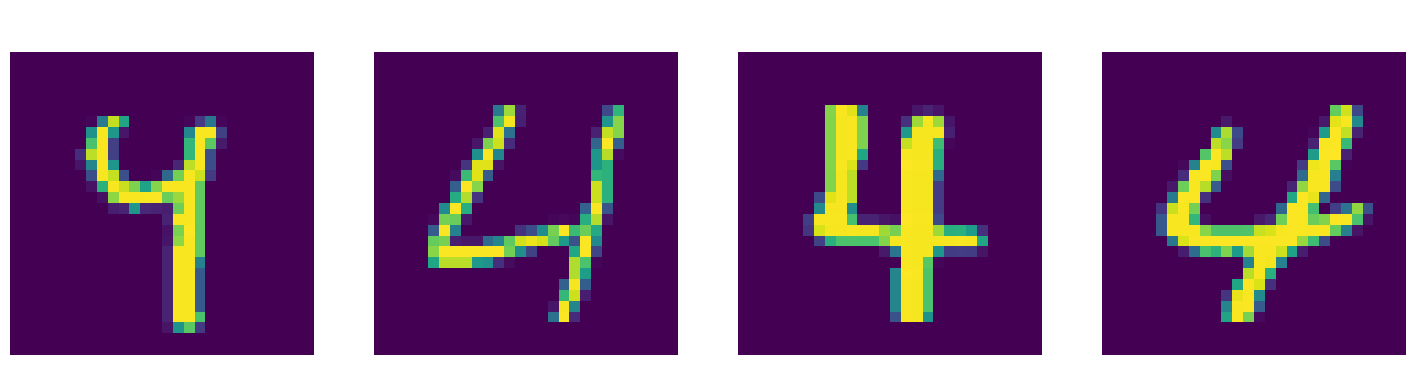

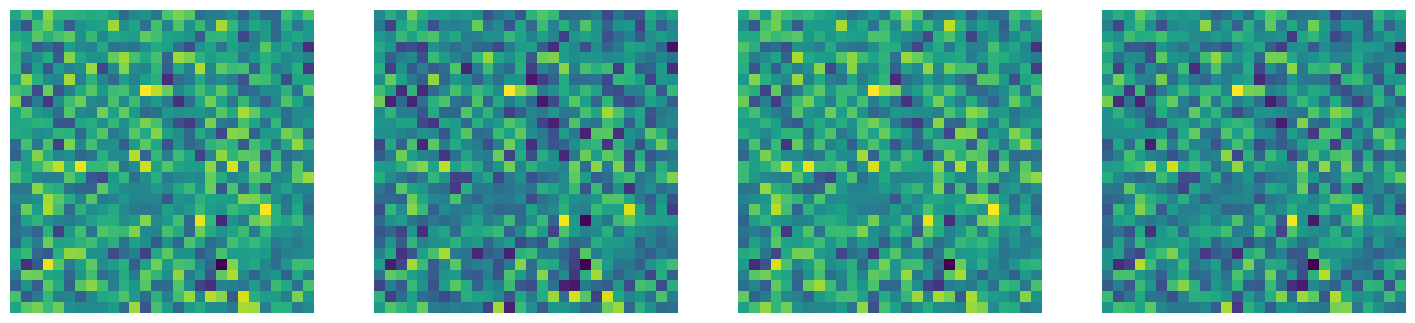

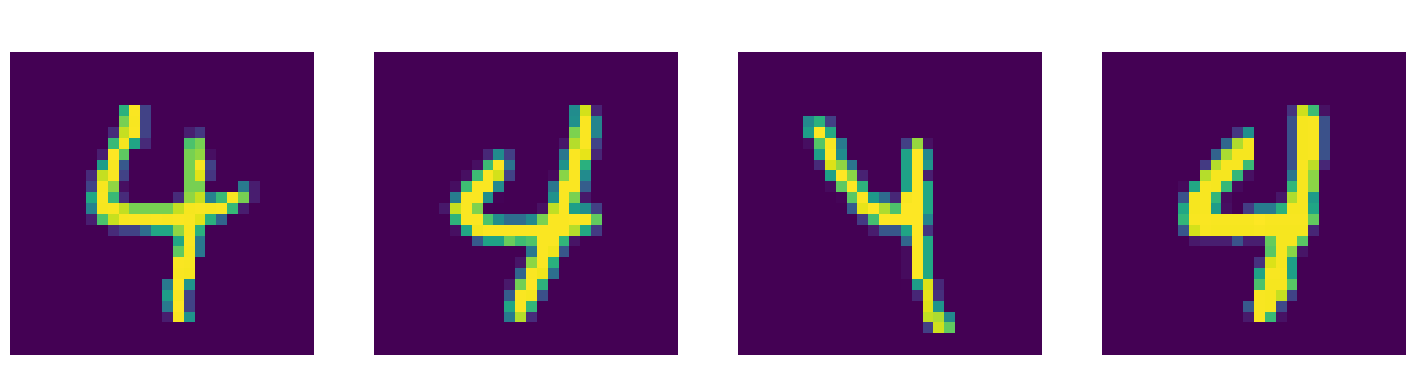

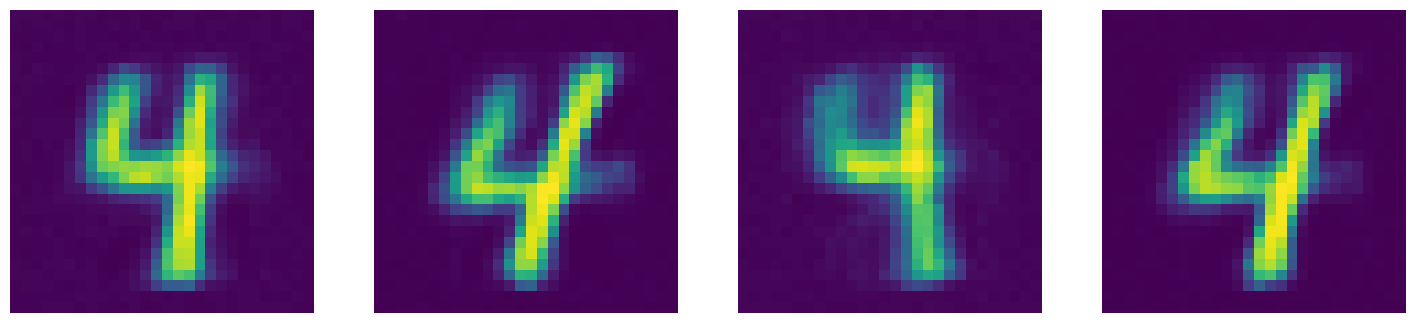

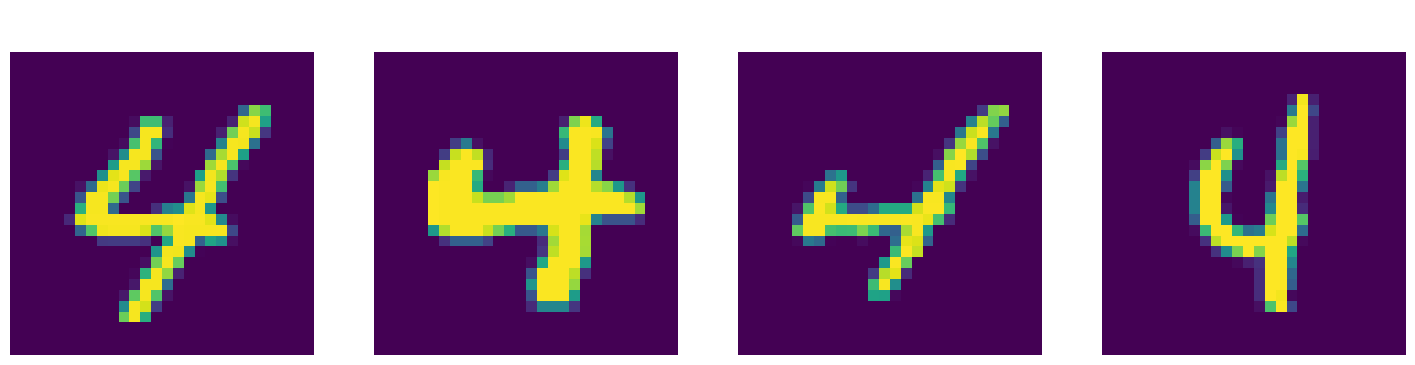

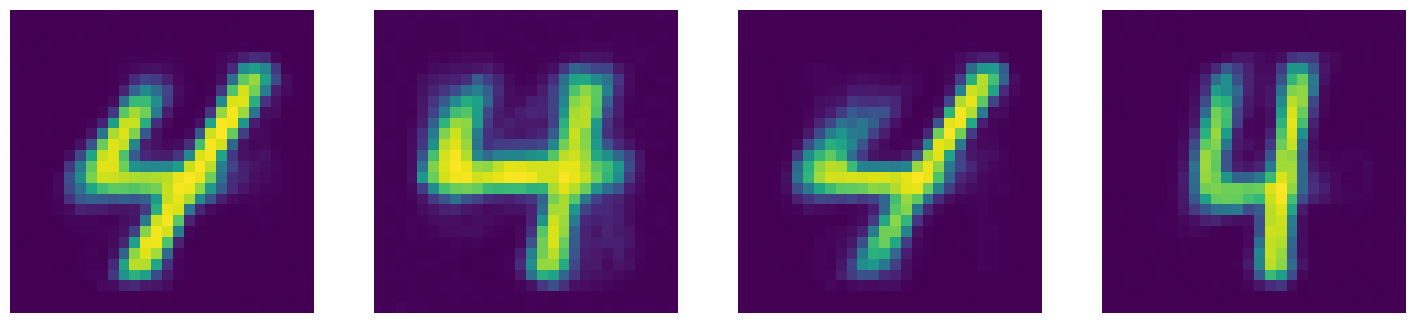

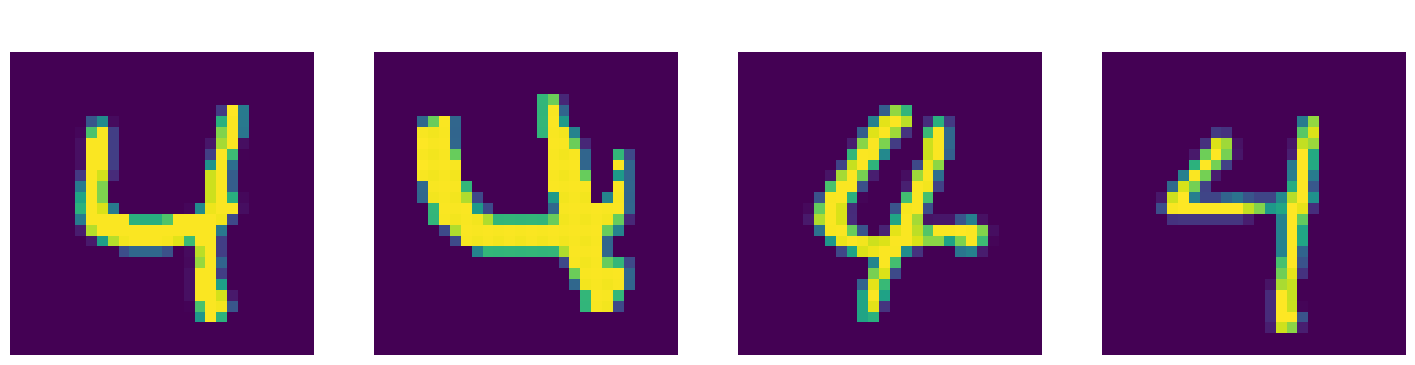

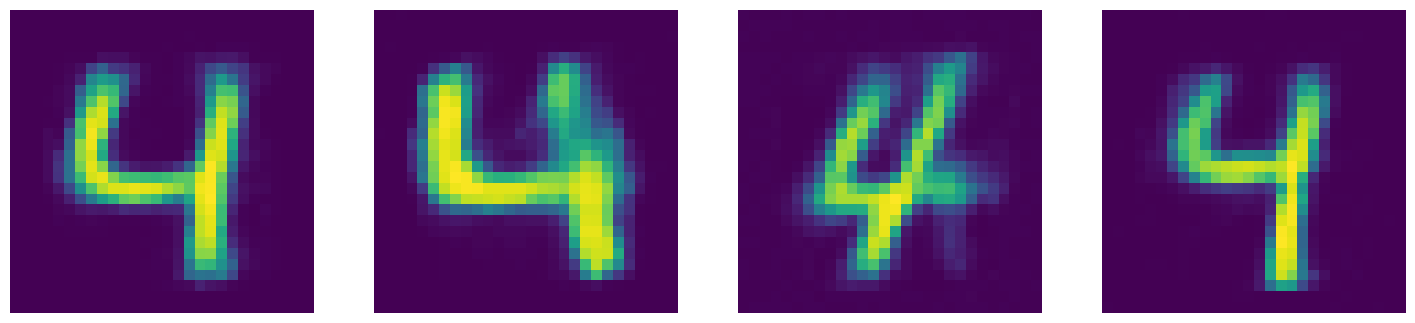

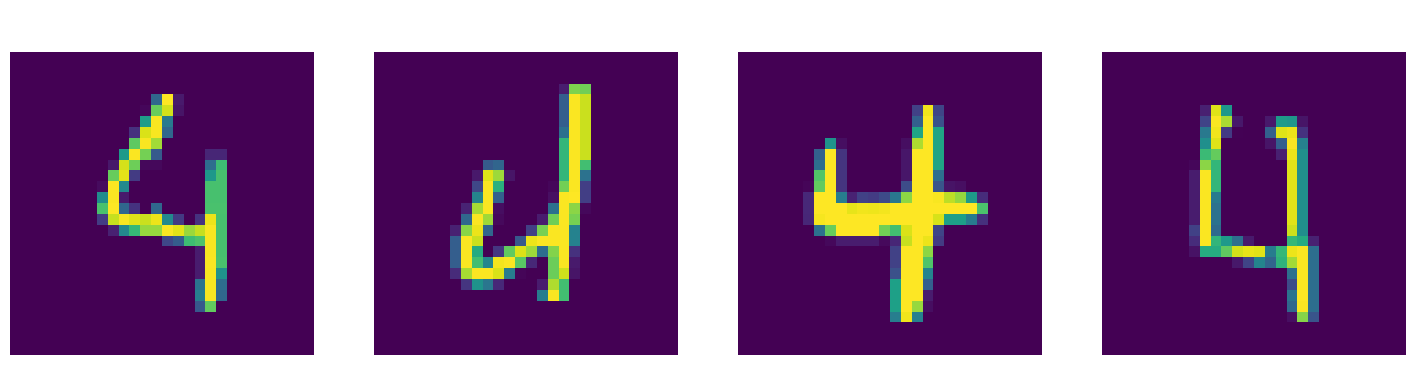

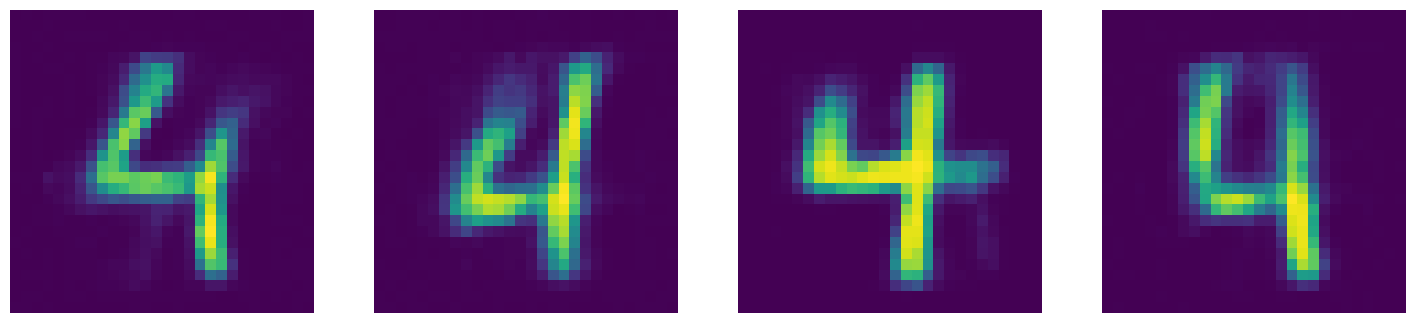

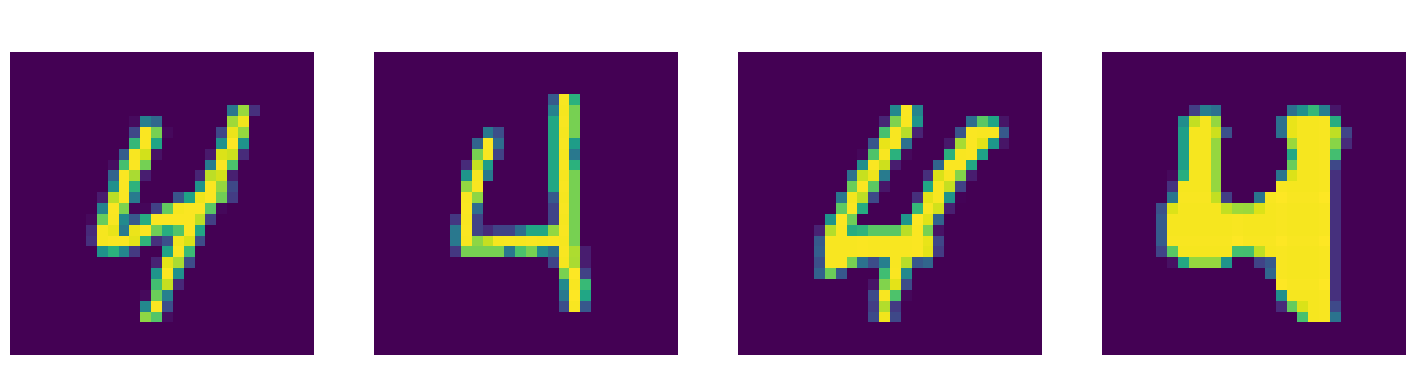

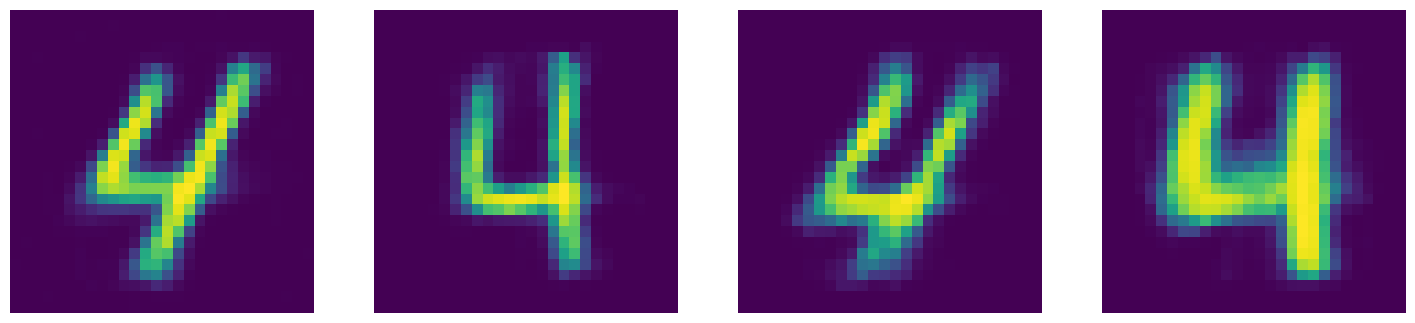

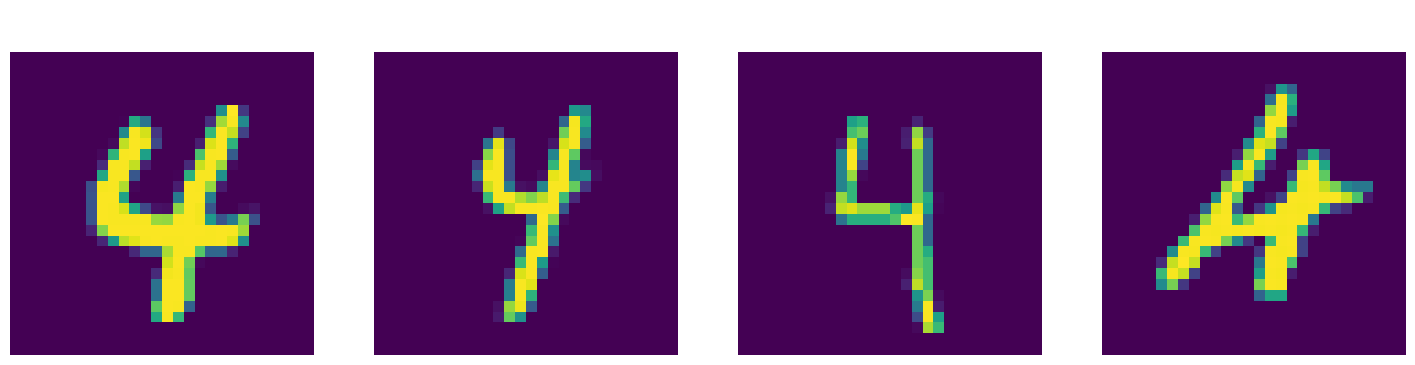

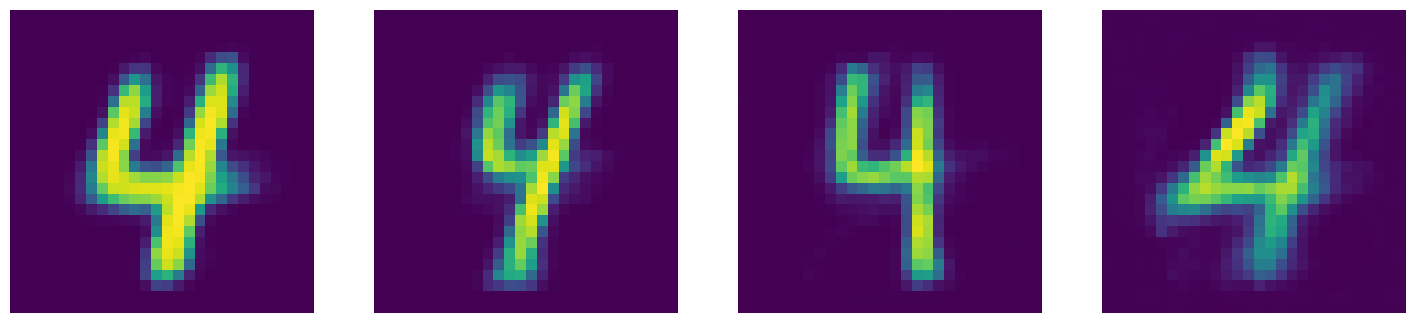

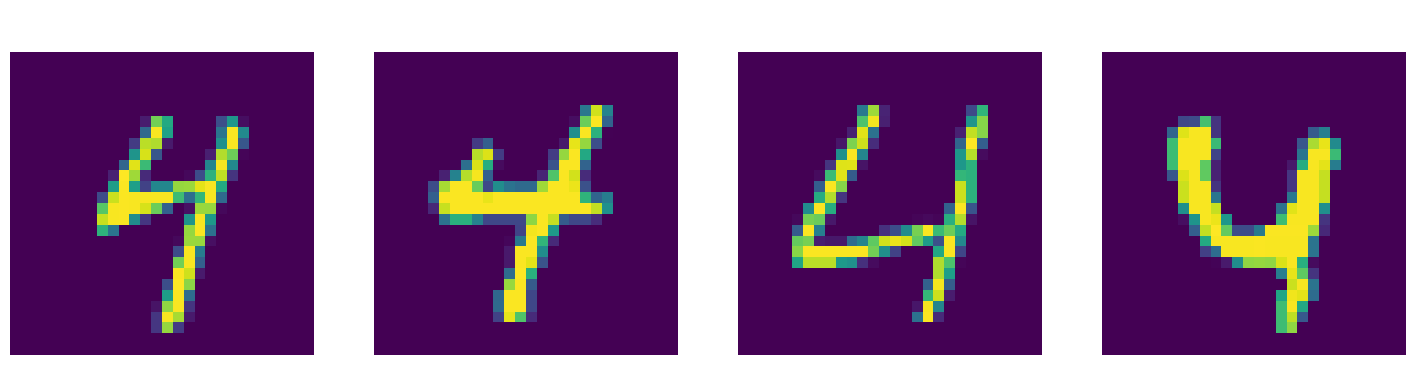

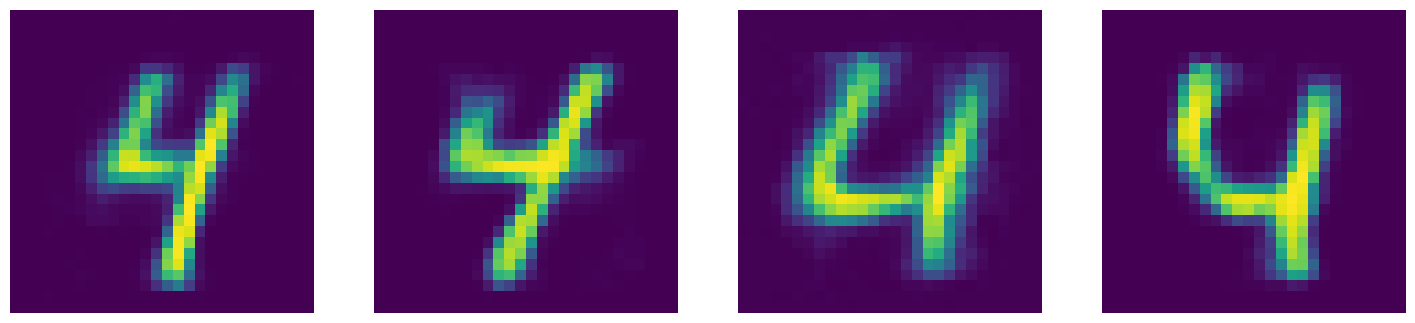

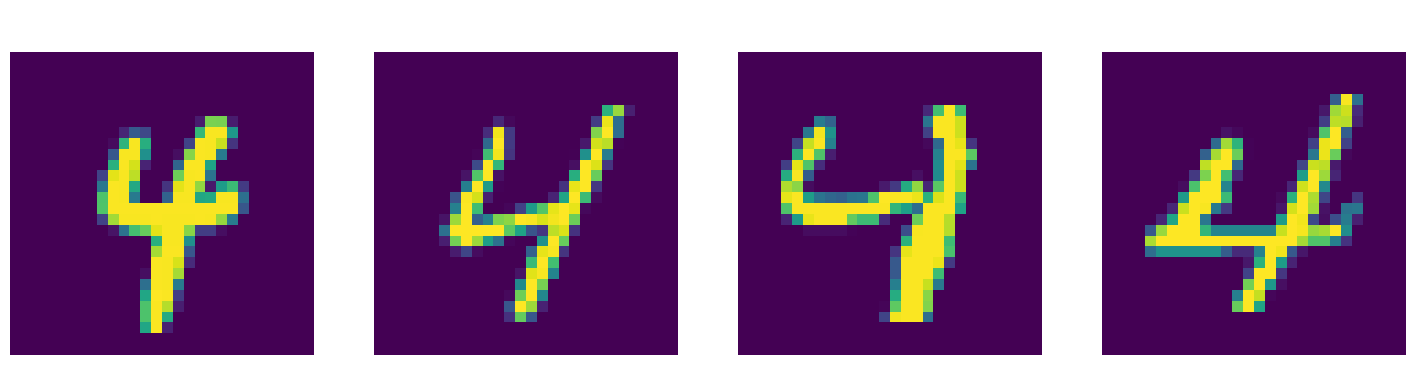

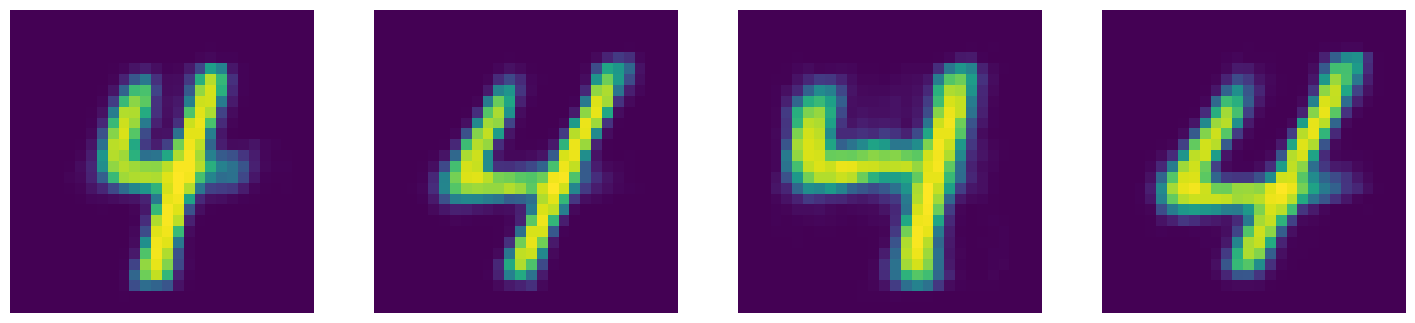

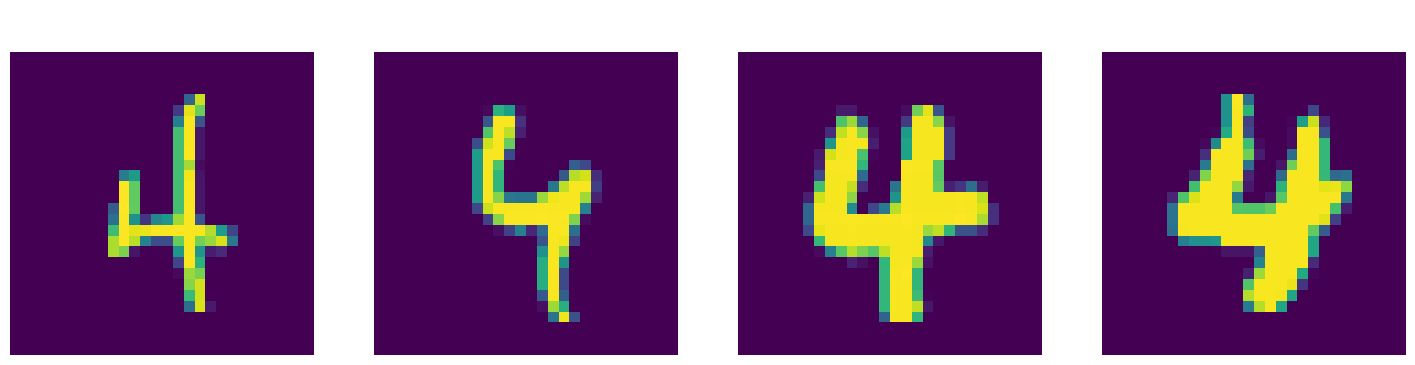

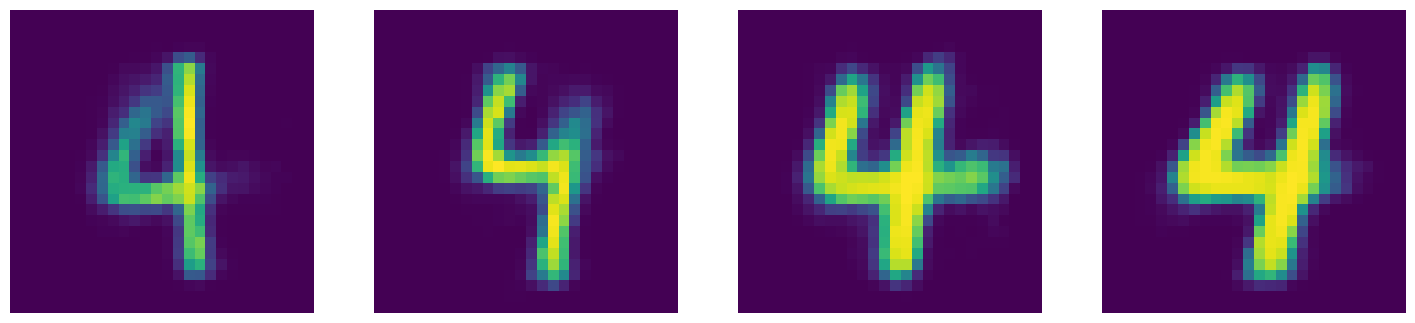

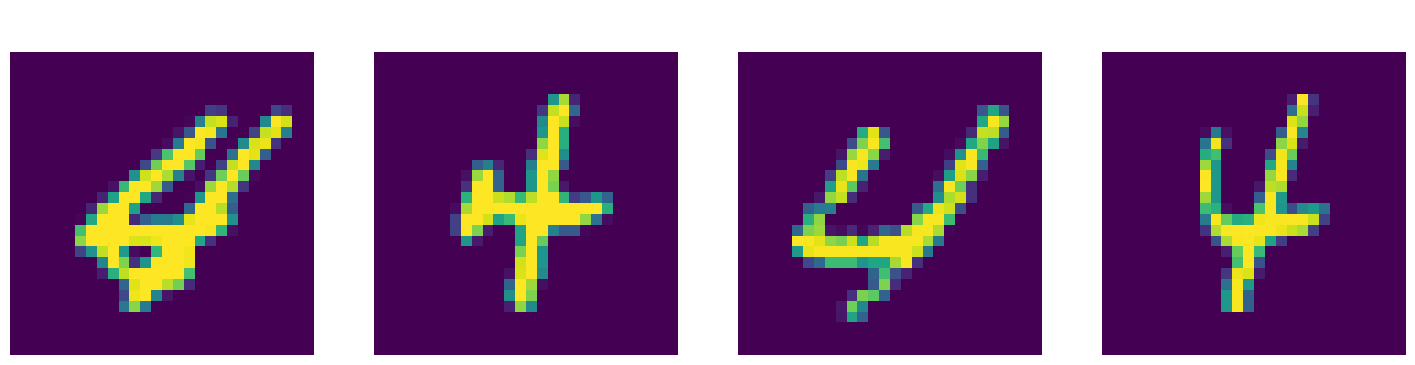

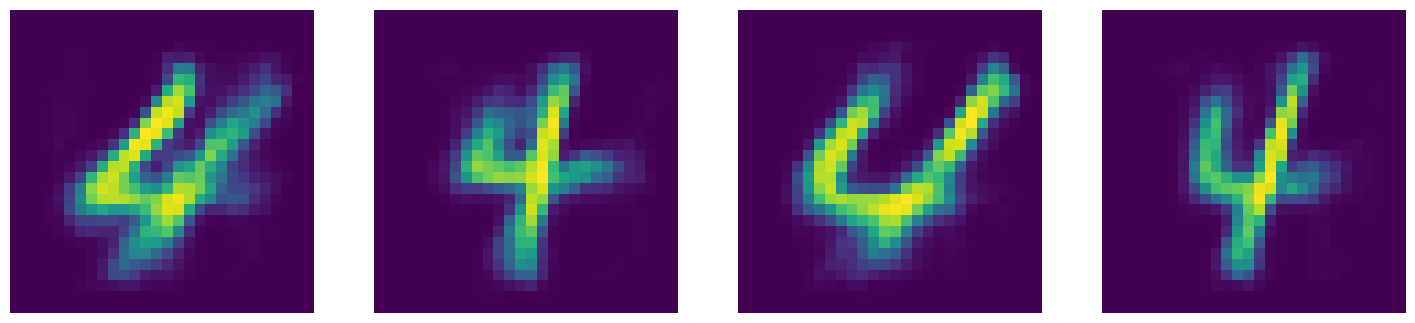

In [140]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

====> Test set loss: 2.0508
torch.Size([8, 1, 28, 28])
torch.Size([8, 28, 28])
Diff score: 0.1737663894891739
Diff score: 0.20361748337745667
Diff score: 0.19275708496570587
Diff score: 0.17193332314491272


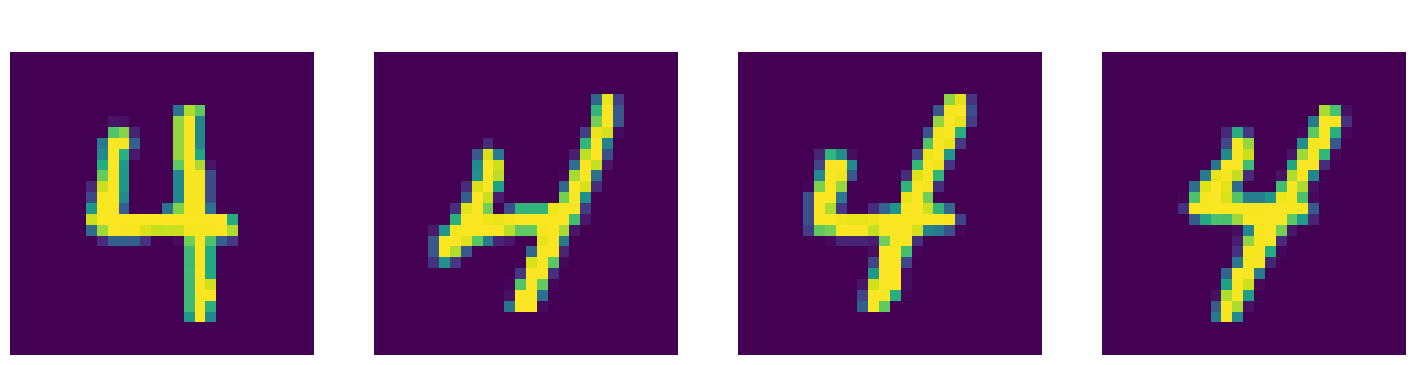

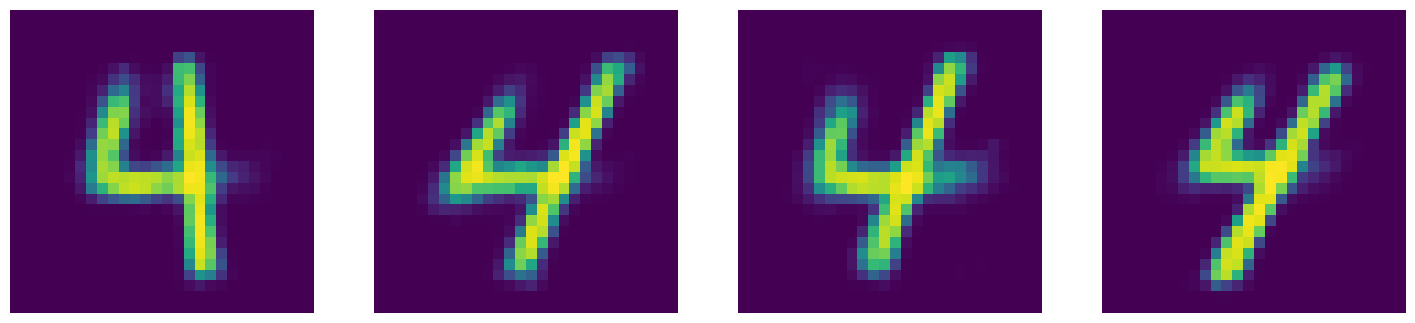

In [142]:
codes = dict(μ=list(), logσ2=list(), y=list())
# Testing
means, logvars, labels = list(), list(), list()
with torch.no_grad():
    model.eval()
    test_loss = 0
    for x, y in test_loader:
        x = x.to(device)
        # ===================forward=====================
        x_hat, mu, logvar = model(x)
        test_loss += loss_function(x_hat, x, mu, logvar).item()
        # =====================log=======================
        means.append(mu.detach())
        logvars.append(logvar.detach())
        labels.append(y.detach())
# ===================log========================
codes['μ'].append(torch.cat(means))
codes['logσ2'].append(torch.cat(logvars))
codes['y'].append(torch.cat(labels))
test_loss /= len(test_loader.dataset)
print(f'====> Test set loss: {test_loss:.4f}')
display_images(x, x_hat, 1, f'Epoch {epoch}')

In [143]:
torch.Tensor(codes['μ'][0])

tensor([[ 0.1175,  1.3761,  1.2770,  ..., -0.1105, -0.0188,  0.8123],
        [-0.0507, -1.1663,  1.4700,  ..., -0.1088, -0.6395,  1.1844],
        [-0.0811, -0.9969,  0.2404,  ..., -0.1439, -1.7188,  0.4670],
        ...,
        [ 0.1007,  0.7846,  0.1536,  ...,  0.0308, -0.5587, -0.5468],
        [-0.1286,  0.6843,  0.6921,  ..., -0.2518, -0.5606, -0.3629],
        [ 0.0339, -0.3577, -0.0994,  ..., -0.0510,  1.4099, -0.8091]])

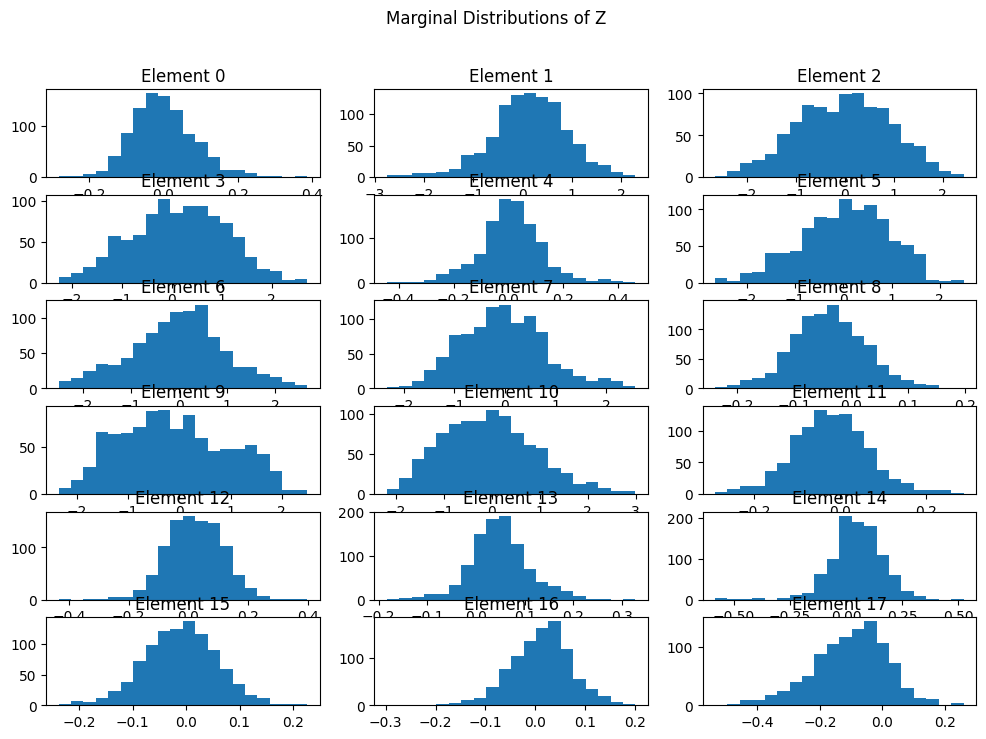

In [145]:
test_mu_tensor = torch.Tensor(codes['μ'][0])
std_fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12,8))
std_fig.suptitle('Marginal Distributions of Z')
for i in range(18):
    ax = axes[int(i/3),i%3]
    ax.hist(test_mu_tensor[:,i].numpy(), 20)
    ax.set_title(F"Element {i}")
plt.show()

In [149]:
import pandas as pd
df = pd.DataFrame(test_mu_tensor.numpy())
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4
0,1.000000,0.290156,-0.496818,-0.186036,-0.215787
1,0.290156,1.000000,-0.173030,0.070816,-0.172126
2,-0.496818,-0.173030,1.000000,-0.059305,0.047125
3,-0.186036,0.070816,-0.059305,1.000000,0.034056
4,-0.215787,-0.172126,0.047125,0.034056,1.000000


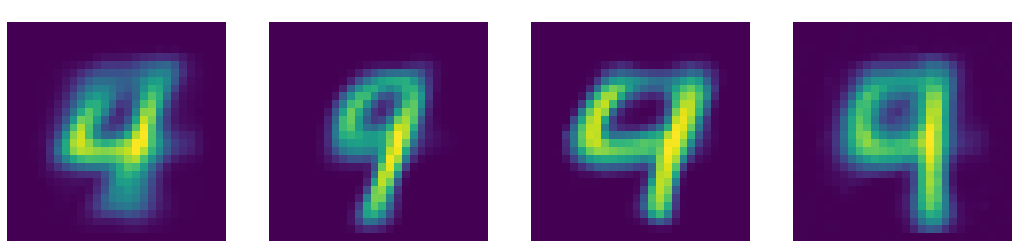

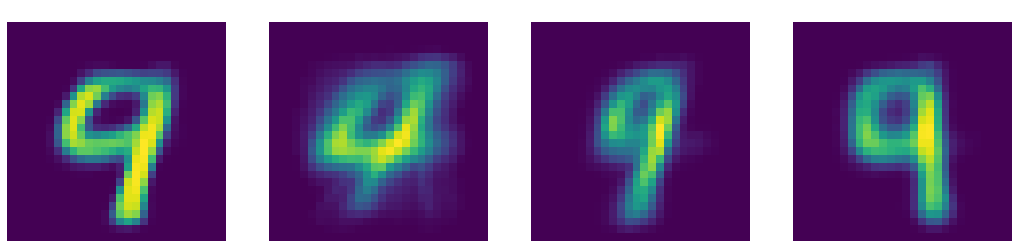

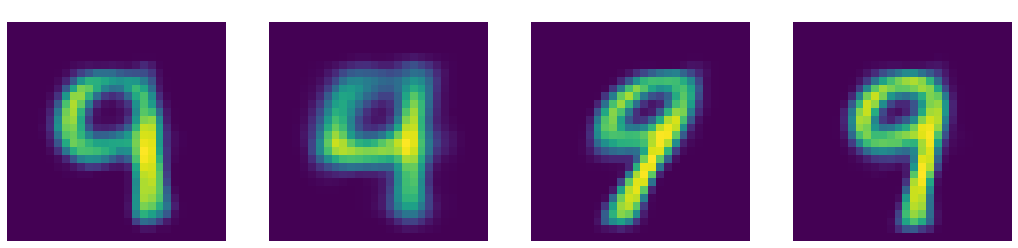

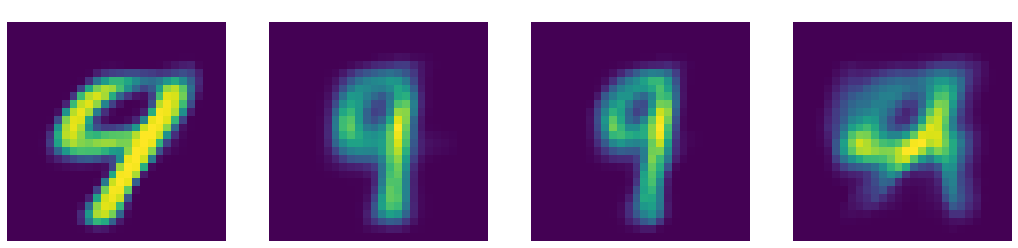

In [59]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
# sample = model.decoder(torch.from_numpy(x0).type(torch.FloatTensor))
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

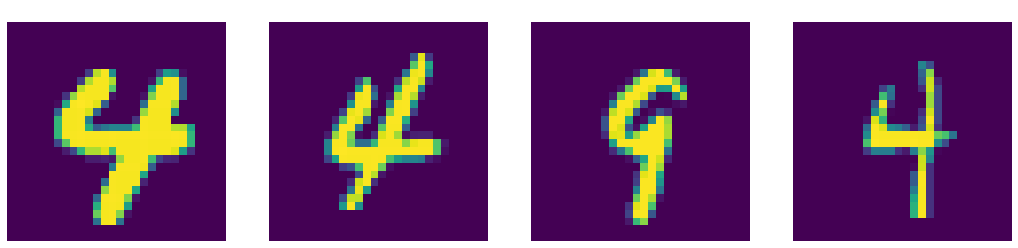

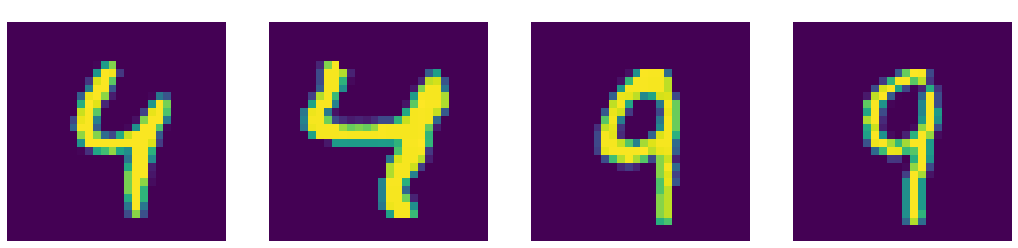

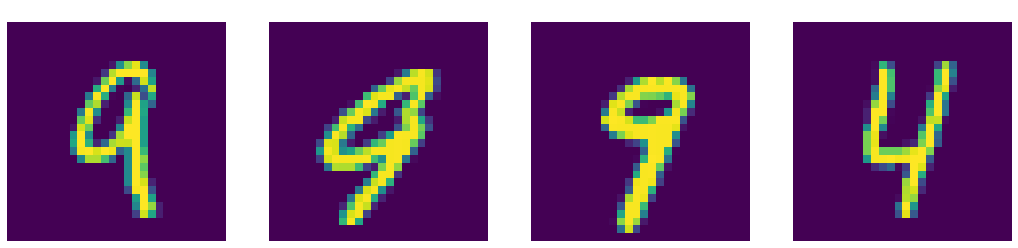

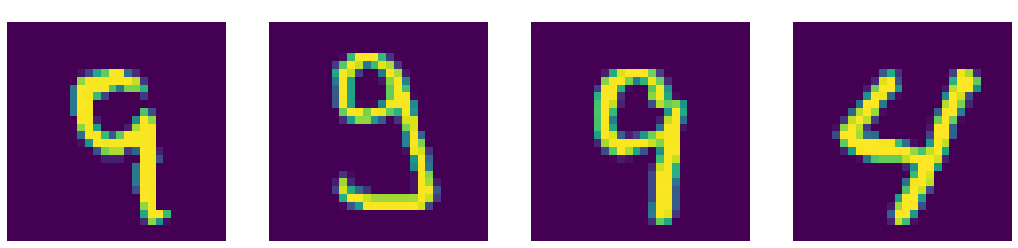

In [127]:
# Display last test batch

display_images(None, x, 4, count=True)

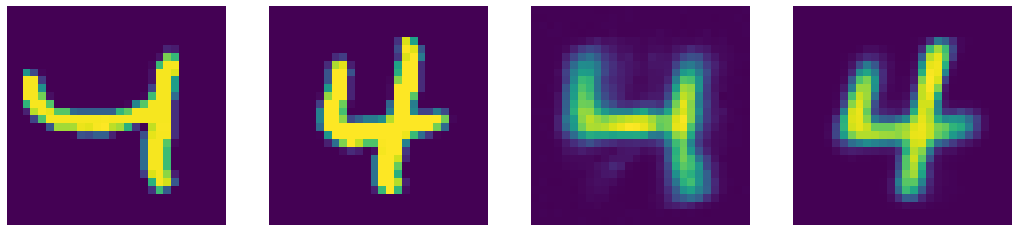

In [62]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

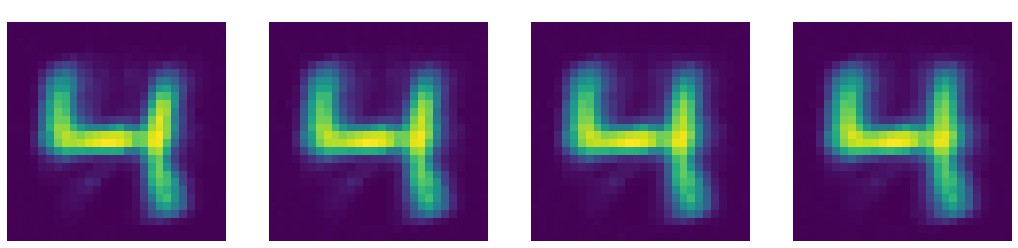

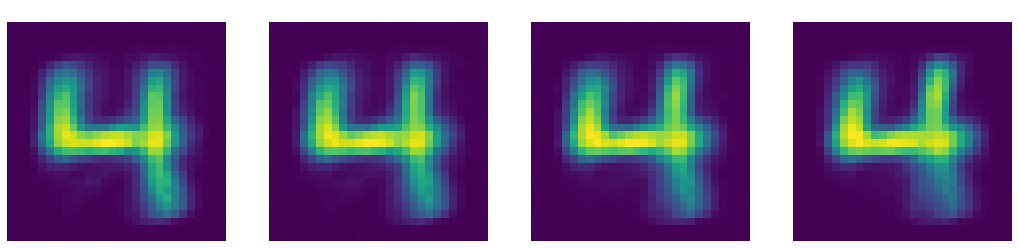

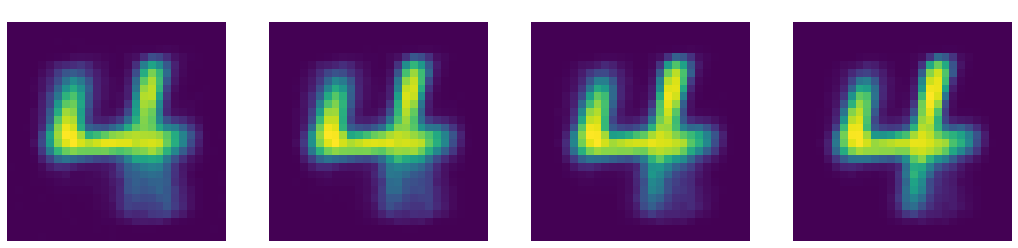

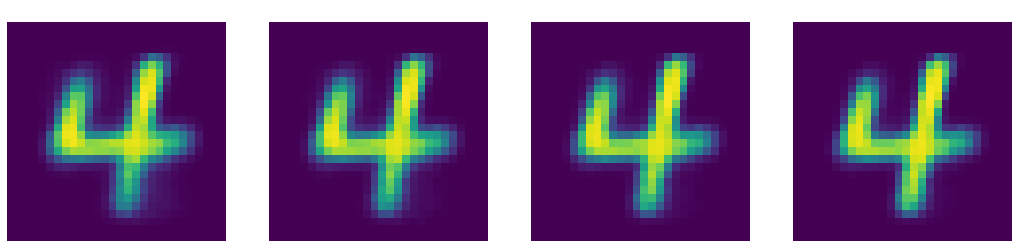

In [63]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [53]:
import numpy as np
from sklearn.manifold import TSNE
from res.plot_lib import set_default

ModuleNotFoundError: No module named 'res'

In [ ]:
set_default(figsize=(15, 4))

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)